## Drifters and Cmems data Notebook

### Introduction
This notebook aims to analyze the velocity data from drifters within the tropical Atlantic Ocean. It involves visualizing drifter velocity data, interpolating CMEMS data onto drifter data, and comparing the velocities between drifters and CMEMS.

### Data Sources
- Drifter Data:
  - Source: NOAA
  - Data Product: Global Drifter Program Current of NOAA
  - Collection Frequency: Every 6 hours
  - Total Number of Drifters: 136
  - link : https://erddap.aoml.noaa.gov/gdp/erddap/tabledap/drifter_6hour_qc.html
  - Periode : period : 2023-03-30 to 2023-07-09

- CMEMS Data:
  - Source: Copernicus Marine
  - Collection Frequency: Every 12 hours
  - Data Product: MULTIOBS_GLO_PHY_MYNRT_015_003
  - link :   https://doi.org/10.48670/mds-00327
  - download data : https://data.marine.copernicus.eu/product/MULTIOBS_GLO_PHY_MYNRT_015_003/download
  - Periode : period : 2023-03-30 to 2023-07-09

### Tasks

#### 1. Visualization of Drifter Velocity Data
- Plot the Eastward (ve) and Northward (vn) velocity as a function of time for a selected drifter.

#### 2. Interpolation of CMEMS Data on Drifter Data
- Interpolate CMEMS data onto the time series of the selected drifter data.

#### 3. Comparison between Drifter Velocities and Interpolated CMEMS Velocities
- Visualize the correlation and regression between drifter velocities (ve, vn) and interpolated CMEMS between the two datasets.
- Plot time series of both drifter velocities and interpolated CMEMS velocities.
-High-frequency filtering of the inertial sensorl

## Import Library


In [73]:
import pandas as pd
import numpy as np
import xarray as xr
import numpy
from datetime import datetime, timedelta
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
from scipy.signal import hann, convolve
from scipy.stats import linregress
from scipy.stats import pearsonr

## Read Drifter Data


In [74]:
fn='./drifter_6hour_qc_c452_ec74_11dc_U1720711192841.nc';
ds=xr.open_dataset(fn);

## Extract Coordinates and Variables


In [75]:
ve_curr = ds.ve.values
vn_curr = ds.vn.values
sst = ds.sst.values
lon = ds.longitude.values
lat = ds.latitude.values
time = ds.time.values

## Creation of Pandas Array for Drifter Data


In [76]:
data = {
    'longitude': lon,
    'latitude' : lat,
    'time'     : time,
    've'       : ve_curr,
    'vn'       : vn_curr,
    'sst'      : sst
}

df = pd.DataFrame(data)

## Selecting Drifter Data


In [77]:
# Test: Our selected drifter has 372 observations.  

df_1 = df[22657:23061]

# Arrange to begin with index 0

In [78]:
ve_curr_2 = df_1.ve.values
vn_curr_2 = df_1.vn.values
sst_2 = df_1.sst.values
lon_2 = df_1.longitude.values
lat_2 = df_1.latitude.values
time_2 = df_1.time.values

In [79]:
data = {
    'longitude': lon_2,
    'latitude' : lat_2,
    'time'     : time_2,
    've'       : ve_curr_2,
    'vn'       : vn_curr_2,
    'sst'      : sst_2
}

df_2 = pd.DataFrame(data)

## Space evolution of Eastward (ve) and Northward (vn) Velocity 

## Case of ve

The drifter is moving mainly northward.


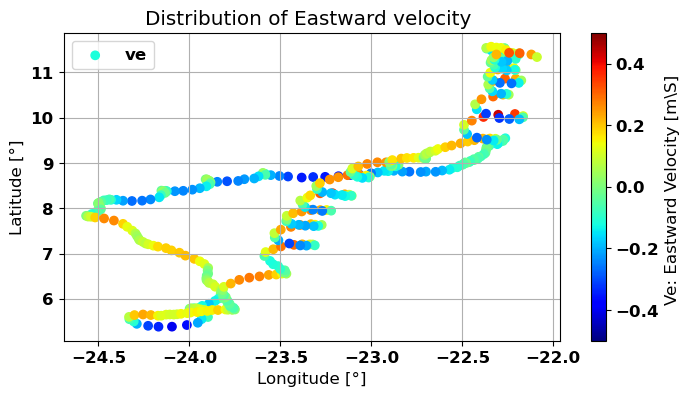

In [80]:
# Assuming you have a DataFrame named df with 'time' and 've' columns
# Plot ve as a function of time
plt.figure(figsize=(8, 4))
plt.scatter(df_2['longitude'], df_2['latitude'], c= df_2['ve'],vmin=-0.5, vmax=0.5, cmap='jet', marker='o')

# Add title, axis labels, grid and legend
plt.title('Distribution of Eastward velocity ')
plt.xlabel('Longitude [°]')
plt.ylabel('Latitude [°]')
plt.grid(True)
plt.colorbar(label='Ve: Eastward Velocity [m\S] ')

# Example of drifter trajectory data (latitude, longitude)
longitude = df_2['longitude']
latitude = df_2['latitude']

# Calculating position changes
delta_lat = np.diff(latitude)
delta_lon = np.diff(longitude)

# Determining the general direction of movement
if np.abs(delta_lat.sum()) > np.abs(delta_lon.sum()):
    if delta_lat.sum() > 0:
        direction = "northward"
    else:
        direction = "southward"
else:
    if delta_lon.sum() > 0:
        direction = "eastward"
    else:
        direction = "westward"

print(f"The drifter is moving mainly {direction}.")

plt.legend(['ve'])
plt.savefig("fig6 mode.png")
plt.show()

## Case of vn

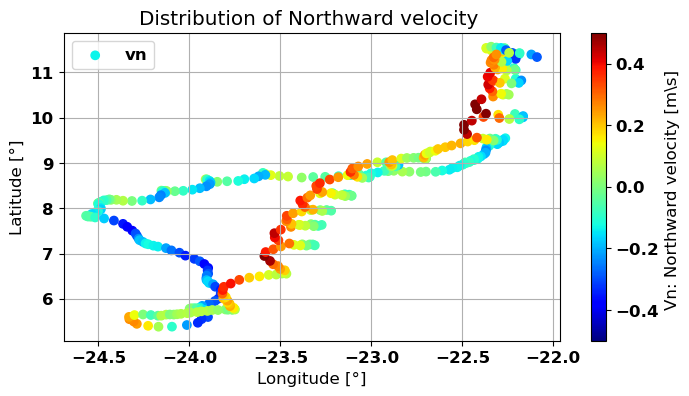

In [81]:
# Assuming you have a DataFrame named df with 'time' and 'vn' columns
# Plot ve as a function of time
plt.figure(figsize=(8, 4))
plt.scatter(df_2['longitude'], df_2['latitude'], c= df_2['vn'],vmin=-0.5, vmax=0.5, cmap='jet', marker='o')

# Add title, axis labels, grid and legend
plt.title('Distribution of Northward velocity ')
plt.xlabel('Longitude [°]')
plt.ylabel('Latitude [°]')
plt.grid(True)
plt.colorbar(label='Vn: Northward velocity [m\s] ')
plt.legend(['vn'])
plt.savefig("fig7 mode.png")
plt.show()

## Now let's interpolate the CMEMS data onto the grid of the drifter data.

### Case of Geostrophic Velocity Anomalies: Zonal Component (ugos) 


- In this step, we interpolate the ugos and vgos variables from the CMEMS data ve and vn respectively variable of the selected drifter.

- We utilize the linear interpolation method for this process. The interpolation is performed based on the variables of longitude, latitude, and important timestamps.

- This allows us to make comparisons and identify differences between drifter variables and CMEMS variables obtained through interpolations.

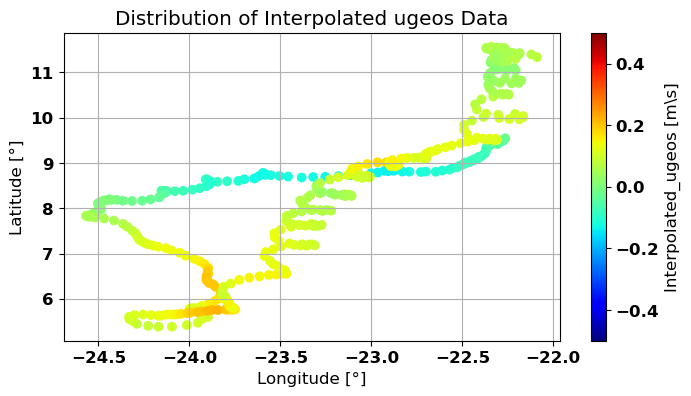

In [82]:
# Chargement des données des bouées dérivantes à partir du DataFrame
df_bouees = df_2  

# Chargement des données satellitaires à partir du fichier netCDF
ds_satellitaires = xr.open_dataset('ugos_vgos.nc')   
 
# Extraction des données de courant des bouées
bouees_courant_u = df_bouees['ve']

# Extraction des données de courant satellitaires pour les mêmes positions spatiales et temporelles que les bouées
latitudes = df_bouees['latitude']
longitudes = df_bouees['longitude']
temps = df_bouees['time']

satellitaires_courant_1 = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['ugos'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_courant_1.append(courant)

# Plot the interpolated data
plt.figure(figsize=(8, 4))
plt.scatter(df_2['longitude'], df_2['latitude'], c= satellitaires_courant_1,vmin=-0.5, vmax=0.5, cmap='jet', marker='o')

# Add title, axis labels, grid and colorbar
plt.title('Distribution of Interpolated ugeos Data')
plt.xlabel('Longitude [°]')
plt.ylabel('Latitude [°]')
plt.grid(True)
plt.colorbar(label='Interpolated_ugeos [m\s]')
plt.savefig("fig8 mode.png")
plt.show()

### Case of Geostrophic Velocity Anomalies: Meridional Component (vgos) 

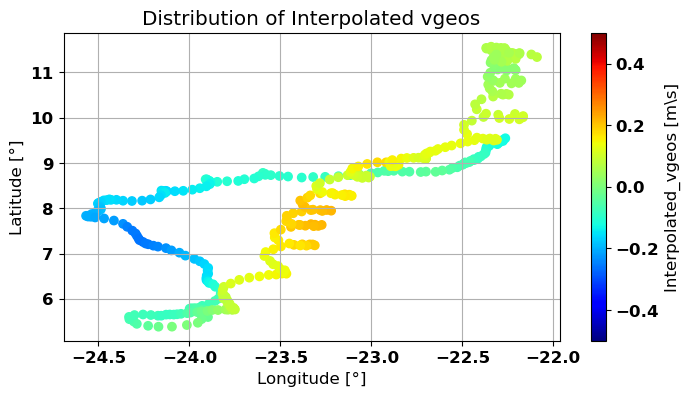

In [83]:
# Chargement des données des bouées dérivantes à partir du DataFrame
df_bouees = df_2
 
# Chargement des données satellitaires à partir du fichier netCDF
ds_satellitaires = xr.open_dataset('ugos_vgos.nc')   
 
# Extraction des données de courant des bouées
bouees_courant_v = df_bouees['vn']

# Extraction des données de courant satellitaires pour les mêmes positions spatiales et temporelles que les bouées
latitudes = df_bouees['latitude']
longitudes = df_bouees['longitude']
temps = df_bouees['time']

satellitaires_courant_2 = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['vgos'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_courant_2.append(courant)

# Plot the interpolated data
plt.figure(figsize=(8, 4))
plt.scatter(df_2['longitude'], df_2['latitude'], c= satellitaires_courant_2,vmin=-0.5, vmax=0.5, cmap='jet', marker='o')

# Add title, axis labels, grid and colorbar
plt.title('Distribution of Interpolated vgeos')
plt.xlabel('Longitude [°]')
plt.ylabel('Latitude [°]')
plt.grid(True)
plt.colorbar(label='Interpolated_vgeos [m\s]')
plt.savefig("fig9 mode.png")
plt.show()

## Now Let's Compare Drifter Speeds and  CMEMS Speeds

## Comparison between ve and ugosa


## Using Regression and Correlation

Corrélation de Pearson: 0.4480353029598684
Valeur de p (p-value): 2.425746345943193e-21


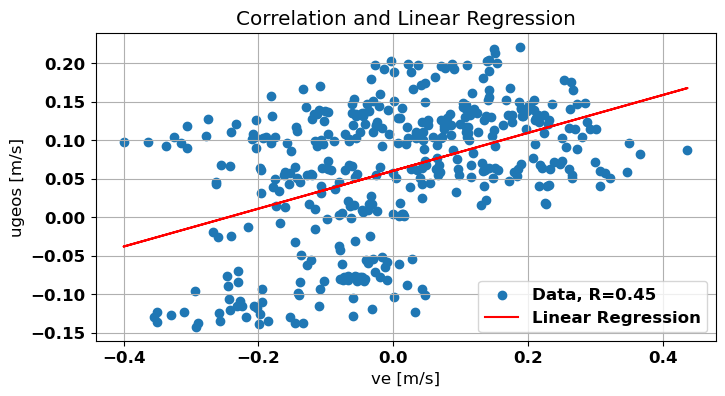

In [84]:
# According to the following, we can simply note that the correlation between "ve" and "ugosa_interpolate" is 0.45. 
# This means that there is a positive and moderate relationship  between this two variables.
# Calcul de la corrélation spatiale et temporelle Pearson
correlation, p_value = pearsonr(bouees_courant_u, satellitaires_courant_1)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_u,satellitaires_courant_1)

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_u,satellitaires_courant_1, label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_u, slope*bouees_courant_u + intercept, color='red', label='Linear Regression')
plt.xlabel('ve [m/s]')
plt.ylabel('ugeos [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'
plt.savefig("fig10 mode.png")
plt.show()

## Using Time Series

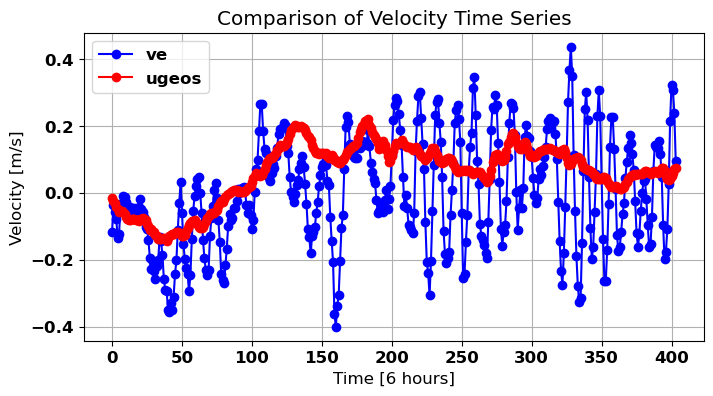

In [85]:
 # Plot time series
plt.figure(figsize=(8, 4))
plt.plot(bouees_courant_u, color='Blue', marker='o', linestyle='-',label='ve')
plt.plot(satellitaires_courant_1, color='RED', marker='o', linestyle='-', label='ugeos')
plt.legend([f'Correlation: {correlation:.2f}'], loc='upper left')

# Add title, axis labels, grid and legend 
plt.title('Comparison of Velocity Time Series')
plt.xlabel('Time [6 hours]')
plt.ylabel('Velocity [m/s]')
plt.grid(True)
plt.legend()
plt.savefig("fig11 mode.png")
plt.show()

## Comparison between vn and vgosa

## Using Regression and Correlation

Corrélation de Pearson: 0.5867341741379963
Valeur de p (p-value): 9.83012134616361e-39


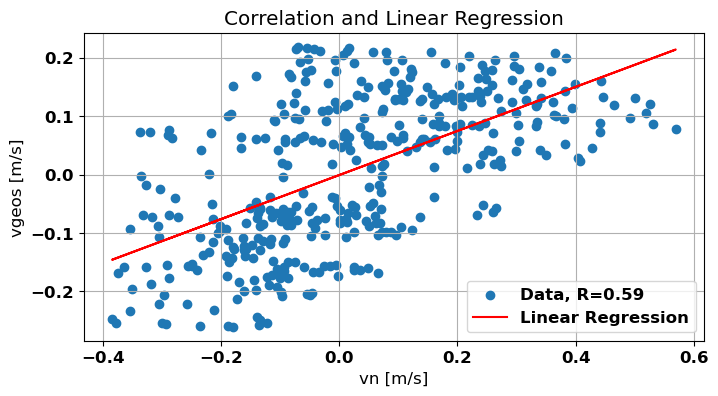

In [86]:
# According to the following, we can simply note that the correlation between "ve" and "ugosa_interpolate" is 0.59. 
# This means that there is a positive and moderate relationship  between this two variables.
# Calcul de la corrélation spatiale et temporelle Pearson
correlation, p_value = pearsonr(bouees_courant_v, satellitaires_courant_2)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_v,satellitaires_courant_2)

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_v,satellitaires_courant_2, label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_v, slope*bouees_courant_v + intercept, color='red', label='Linear Regression')
plt.xlabel('vn [m/s]')
plt.ylabel('vgeos [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'
plt.savefig("fig12 mode.png")
plt.show()

## Using Time Series

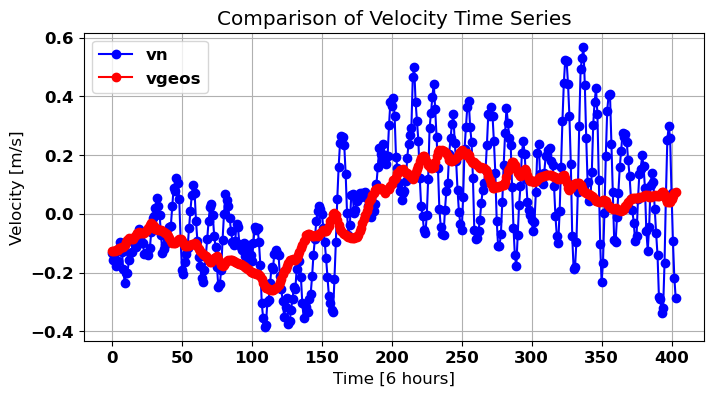

In [87]:
 # Plot time series
plt.figure(figsize=(8, 4))
plt.plot(bouees_courant_v, color='Blue', marker='o', linestyle='-',label='vn')
plt.plot(satellitaires_courant_2, color='RED', marker='o', linestyle='-', label='vgeos')
plt.legend([f'Correlation: {correlation:.2f}'], loc='upper left')

# Add title, axis labels, grid and legend 
plt.title('Comparison of Velocity Time Series')
plt.xlabel('Time [6 hours]')
plt.ylabel('Velocity [m/s]')
plt.grid(True)
plt.legend()
plt.savefig("fig13 mode.png")
plt.show()

# Application of a linear Hanning filter at a 24-hour resolution.

## Case of ve

In [88]:
time = np.array(df_2['time'])   
current_data = np.array(df_2['ve'])   

# Parameters of the Hanning filter
window_length = 24  # Length of the Hanning window

# Applying the Hanning filter
window = hann(window_length)  # Create the Hanning window
ve_filter_Han = convolve(current_data, window, mode='same') / sum(window)  # Apply the Hanning filter

C:\Users\PC-M2OA\AppData\Local\Temp\ipykernel_12348\1390957898.py:8: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  window = hann(window_length)  # Create the Hanning window


## Case of vn

In [89]:
time = np.array(df_2['time'])   
current_data = np.array(df_2['vn'])   

# Parameters of the Hanning filter
window_length = 24  # Length of the Hanning window

# Applying the Hanning filter
window = hann(window_length)  # Create the Hanning window
vn_filter_Han = convolve(current_data, window, mode='same') / sum(window)  # Apply the Hanning filter

C:\Users\PC-M2OA\AppData\Local\Temp\ipykernel_12348\2578851579.py:8: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  window = hann(window_length)  # Create the Hanning window


## Comparison between (ve_filter_Han and ugeos) and (vn_filter_Han and vgeos) 

## Using Regression and Correlation

## Case of ve_filter_Han and ugeos

Corrélation de Pearson: 0.7956224282006648
Valeur de p (p-value): 1.5578600823275638e-89


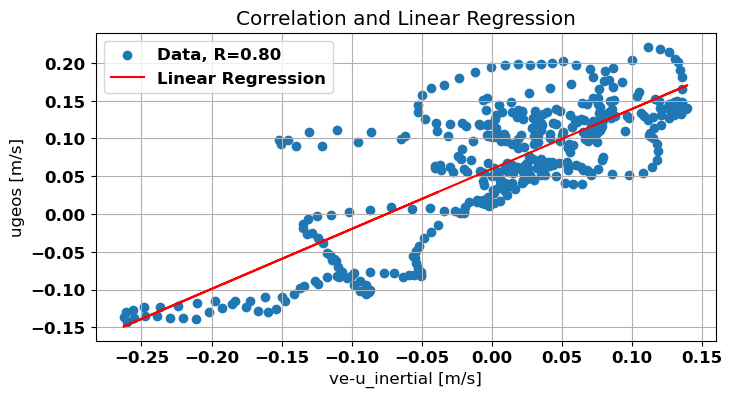

In [90]:
# According to the following, we can simply note that the correlation between "ve_filter" and "ugeos" is 0.80. 
# This means strong relationship between the variables
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_u = ve_filter_Han
correlation, p_value = pearsonr(satellitaires_courant_1,bouees_courant_u)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_u,satellitaires_courant_1)

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_u,satellitaires_courant_1, label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_u, slope*bouees_courant_u + intercept, color='red', label='Linear Regression')
plt.xlabel('ve-u_inertial [m/s]')
plt.ylabel('ugeos [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'
plt.savefig("fig14 mode.png")
plt.show()

## Case of vn_filter_Han and v_total

Corrélation de Pearson: 0.8331068128764463
Valeur de p (p-value): 1.9466418781982183e-105


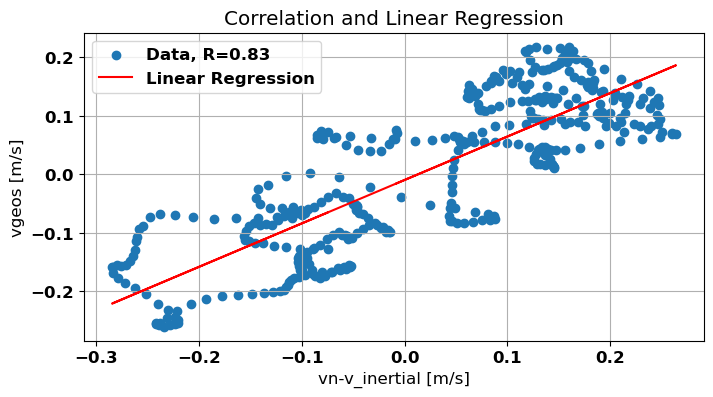

In [91]:
# According to the following, we can simply note that the correlation between "vn" and "vgeos + ve" is 0.83. 
# This means strong relationship between the variables
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_v = vn_filter_Han
correlation, p_value = pearsonr(satellitaires_courant_2,bouees_courant_v)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_v,satellitaires_courant_2)

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_v,satellitaires_courant_2, label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_v, slope*bouees_courant_v + intercept, color='red', label='Linear Regression')
plt.xlabel('vn-v_inertial [m/s]')
plt.ylabel('vgeos [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'
plt.savefig("fig15 mode.png")
plt.show()

## Application of Clement filter 

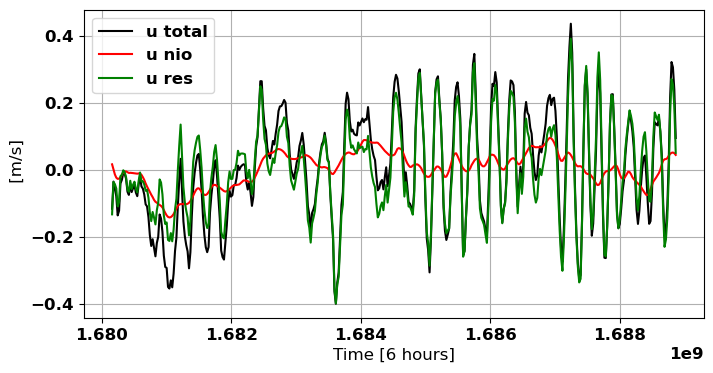

In [92]:
filenc = './drifter_6hour_qc_c452_ec74_11dc_U1720711192841.nc'

with Dataset(filenc, 'r') as fcid:
    time = numpy.array(fcid.variables['time']) # seconds
    u = numpy.array(fcid.variables['ve'])
    v = numpy.array(fcid.variables['vn'])
    lat = numpy.array(fcid.variables['latitude'])

U = u + 1j*v

dt=time[1]-time[0]
fc = 2*2*numpy.pi/86164*numpy.sin(lat.mean()*numpy.pi/180)  # s-1

time_conv = numpy.arange(-3*86400,3*86400+dt,dt)

taul=3*fc**-1
# gl = (numpy.exp(-1j*numpy.outer(fc[:],time_conv))*numpy.exp(-numpy.outer(taul**-2,time_conv**2))).reshape(len(time),len(time_conv))
gl = numpy.exp(-1j*fc*time_conv)*numpy.exp(-taul**-2*time_conv**2)
gl = (gl.T / numpy.sum(numpy.abs(gl), axis=0).T).T

Unio =numpy.convolve(U,gl,'same')

u_nio = numpy.real(Unio)
v_nio = numpy.imag(Unio)

plt.figure(figsize=(8, 4))
plt.plot(time[22657:23061],u[22657:23061], c='k', label='u total')
plt.plot(time[22657:23061],u_nio[22657:23061], c='r', label='u nio')
plt.plot(time[22657:23061],u[22657:23061]-u_nio[22657:23061], c='g', label='u res')
plt.legend()
plt.grid(True)
plt.xlabel('Time [6 hours]')
plt.ylabel(' [m/s]')
plt.savefig("fig16 mode.png")

 ## Comparison between (ve_filter_cl and ugeos) and (vn_filter_cl and vgeos) 

## Case of ve_filter_cl and ugeos

Corrélation de Pearson: 0.827749190512552
Valeur de p (p-value): 6.234732875115356e-103


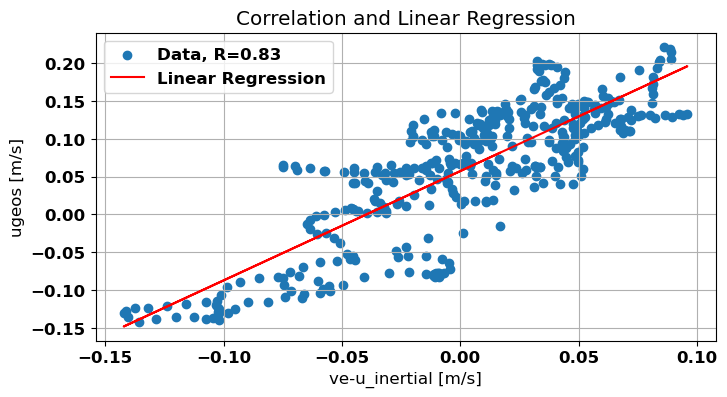

In [93]:
# According to the following, we can simply note that the correlation between "ve_res" and "ugeos" is 0.83. 
# This means strong relationship between the variables
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_u = u_nio[22657:23061]
correlation, p_value = pearsonr(satellitaires_courant_1,bouees_courant_u)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_u,satellitaires_courant_1)

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_u,satellitaires_courant_1, label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_u, slope*bouees_courant_u + intercept, color='red', label='Linear Regression')
plt.xlabel('ve-u_inertial [m/s]')
plt.ylabel('ugeos [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'
plt.savefig("fig17 mode.png")
plt.show()

## Case of vn_filter_cl and vgeos 

Corrélation de Pearson: 0.8481907280476777
Valeur de p (p-value): 5.342040862558651e-113


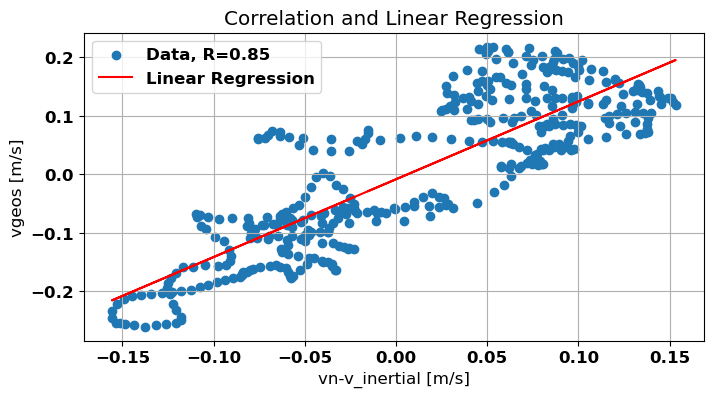

In [94]:
# According to the following, we can simply note that the correlation between "vn" and "vgeos + ve" is 0.85. 
# This means strong relationship between the variables
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_v = v_nio[22657:23061]
correlation, p_value = pearsonr(satellitaires_courant_2,bouees_courant_v)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_v,satellitaires_courant_2)

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_v,satellitaires_courant_2, label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_v, slope*bouees_courant_v + intercept, color='red', label='Linear Regression')
plt.xlabel('vn-v_inertial [m/s]')
plt.ylabel('vgeos [m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'
plt.savefig("fig18 mode.png")
plt.show()

### Time series

### Zonal components currents

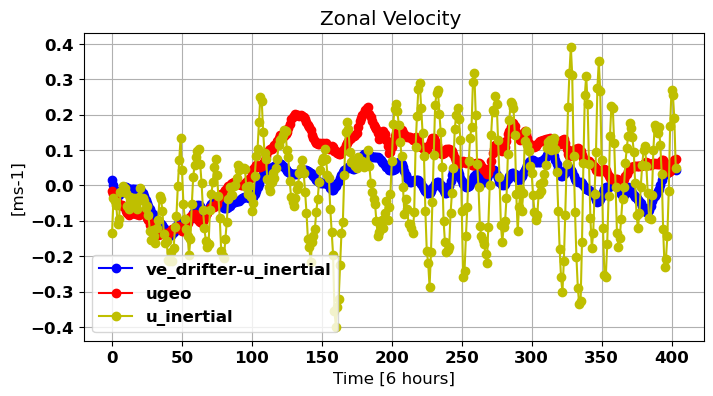

In [95]:
# Tracer le graphique
plt.figure(figsize=(8, 4))
plt.plot(u_nio[22657:23061], marker='o', linestyle='-', color='blue',label='ve_drifter-u_inertial')
plt.plot(satellitaires_courant_1,marker='o', linestyle='-', color='red',label='ugeo')
plt.plot(u[22657:23061]-u_nio[22657:23061], marker='o', linestyle='-', color='y',label='u_inertial')
 
plt.title('Zonal Velocity ')
plt.xlabel('Time [6 hours]')
plt.ylabel('[ms-1]')
plt.grid(True)
plt.legend()
plt.savefig("fig19 mode.png")
plt.show()

### Meridional components currents

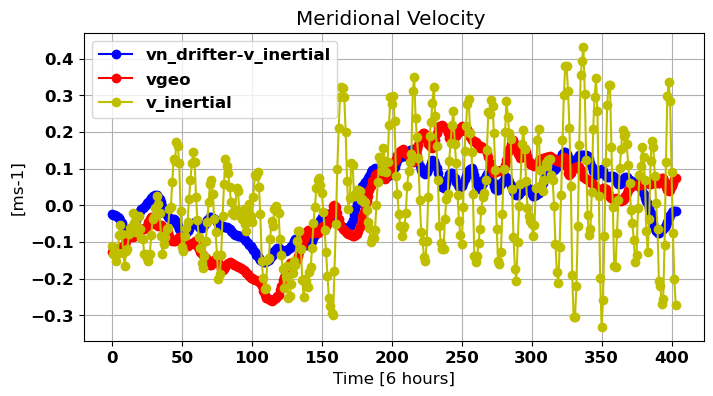

In [96]:
# Tracer le graphique
plt.figure(figsize=(8, 4))
plt.plot(v_nio[22657:23061], marker='o', linestyle='-', color='blue',label='vn_drifter-v_inertial')
plt.plot(satellitaires_courant_2, marker='o', linestyle='-', color='red',label='vgeo')
plt.plot(v[22657:23061]-v_nio[22657:23061], marker='o', linestyle='-', color='y',label='v_inertial')

plt.title('Meridional Velocity ')
plt.xlabel('Time [6 hours]')
plt.ylabel('[ms-1]')
plt.grid(True)
plt.legend()
plt.savefig("fig20 mode.png")
plt.show()

## Conclusion
 - Moderate relationship between the variables ugeos (CMEMS Current) and ve (Drifter Current).
 - Moderate relationship  between vgeos (CMEMS Current) and vn (Drifter Current).
 - Zonal component dominated by the meridional component.
 - Current dominated by the inertial component compared to the Ekman component.
 - Altimetric current measurements are better and can be improved by considering certain components, notably Ekman and inertial components.